# Research Question : Can we identify any trends within Financial Expenditures per country? 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

In [2]:
expend = pd.read_csv("../data_final/AidData_v2.0.csv", dtype={'country_id':str})
expend = expend.loc[pd.notna(expend['Commitment Year']) & (expend['country_id'] != 'Non') & pd.notna(expend['country_id'])].reset_index()
expend['country_id'] = [str(int(x.split('.')[0])) for x in expend['country_id']]

countries = pd.read_csv("../data_final/countries.csv", dtype={'country_id':str})
countries['bri_partner'] = countries['bri_partner'].replace({"unknown": 0}).fillna(0).astype(int)
countries = countries[countries['country_id'] != 'Non']

In [3]:
stats = pd.read_csv("../data_final/world_stats.csv", dtype={'country_id':str})

In [4]:
# Computationally Expensive...
# profile = ProfileReport(expend, title='Financial Expenditures Profiling Report', html={'style':{'full_width':True}})
# profile

## DataFrame Creation

| country | year | bri_country | sum of expenditures in given year | count of expenditures in given year | % projects completed | count_education_projects | count_government_projects | count_health_projects | count_transport_projects | country_energy_projects | GDP  | Population | 
|---|---|---|---|---|---|---|---|---|---|---|---|---|
| str | int | binary | int | int | float | int | int | int | int | int | float | int |


In [5]:
year_adjust = 'Commitment Year'

In [6]:
# create binary representations of 
# Project Completion 
# projects of industries

projects_to_consider = ['EDUCATION', 'GOVERNMENT AND CIVIL SOCIETY', 'HEALTH', 'TRANSPORT AND STORAGE', 'ENERGY', 'EMERGENCY RESPONSE', 'INDUSTRY, MINING, CONSTRUCTION']
dummies = pd.get_dummies(expend['Sector Name'])[projects_to_consider]
expend = expend.join(dummies)

expend['project_completion'] = [1 if x == 'Completion' else 0 for x in expend['Status']]

In [7]:
agg = expend.groupby(['country_id', year_adjust]).agg(
    expend_sum = ('Amount (Constant USD2017)', 'sum'), 
    project_count=('AidData TUFF Project ID', 'count'),
    projects_completed= ('project_completion', 'sum'), 
    education_projects= ('EDUCATION', 'sum'),
    gov_projects= ('GOVERNMENT AND CIVIL SOCIETY', 'sum'),
    health_projects= ('HEALTH', 'sum'),
    transport_projects= ('TRANSPORT AND STORAGE', 'sum'),
    energy_projects= ('ENERGY', 'sum'),
    emergency_projects= ('EMERGENCY RESPONSE', 'sum'),
    construction_projects= ('INDUSTRY, MINING, CONSTRUCTION', 'sum')
)

#agg.reset_index(inplace = True)

In [8]:
stats = stats.loc[(stats['year'] >= 2000) & (stats['year'] <= 2020) & pd.notna(stats['country_id'])]
df = agg.reset_index().merge(stats, left_on=['Commitment Year', 'country_id'], right_on=['year', 'country_id'], how='right')

<AxesSubplot:xlabel='year', ylabel='gdp'>

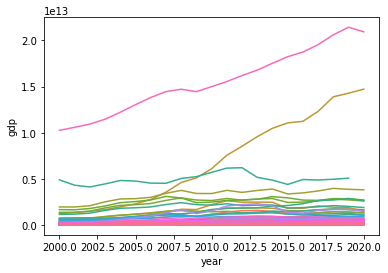

In [9]:
sns.lineplot(data=df, x='year', y='gdp', hue='country', legend=False)

In [10]:
# adding in BRI designation in that year 
df['bri_partner'] = 0
df['time_interpolation'] = 0

for i in range(0, len(countries)):
    year = countries['bri_partner'][i]
    country_id = countries['country_id'][i]
    
    # if the countries data is available in the spreadsheet 
    if len(df.index[df['country_id'] == country_id].tolist()) != 0: # to DO FIND 2021 COUNTRY DATA
        if (year != 2021) & (year != 0):  
            start_range = df.index[(df['year'] >= year) & (df['country_id'] == country_id)].tolist()[0]
            end_range = df.index[(df['year'] >= year) & (df['country_id'] == country_id)].tolist()[-1]
            df.loc[start_range:end_range, 'bri_partner'] = 1

        start_range = df.index[(df['country_id'] == country_id)].tolist()[0]
        end_range = df.index[(df['country_id'] == country_id)].tolist()[-1] + 1
        df['time_interpolation'][start_range:end_range] = df[df['country_id'] == country_id]['gdp'].interpolate(method='index', limit_direction='both')

/tmp/ipykernel_20003/71021425.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_interpolation'][start_range:end_range] = df[df['country_id'] == country_id]['gdp'].interpolate(method='index', limit_direction='both')


In [11]:
# interpolate gdp 
df['gdp'] = [x if pd.notna(x) else y for x, y in zip(df['gdp'], df['time_interpolation'])]

# drop Commitment Year duplicate column
df.drop(columns=['Commitment Year', 'gdp_debt', 'time_interpolation'], inplace = True)

In [12]:
df.fillna(0, inplace=True)

In [13]:
df

,country_id,expend_sum,project_count,projects_completed,education_projects,gov_projects,health_projects,transport_projects,energy_projects,emergency_projects,construction_projects,year,country,population,gdp,bri_partner
0,30,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,Aruba,90866.0,1.873453e+09,0
1,30,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001,Aruba,92892.0,1.920112e+09,0
2,30,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002,Aruba,94992.0,1.941341e+09,0
3,30,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003,Aruba,97016.0,2.021229e+09,0
4,30,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004,Aruba,98744.0,2.228492e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,115,5.154767e+09,6.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2016,Zimbabwe,14030338.0,2.054868e+10,0
4490,115,1.397540e+08,12.0,4.0,1.0,1.0,2.0,1.0,2.0,2.0,0.0,2017,Zimbabwe,14236599.0,1.901533e+10,0
4491,115,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018,Zimbabwe,14438812.0,1.952362e+10,1
4492,115,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,Zimbabwe,14645473.0,1.693243e+10,1


## Balance Determination

In [14]:
df['bri_partner'].value_counts() * 100 / len(df)

0    89.185581
1    10.814419
Name: bri_partner, dtype: float64

In [21]:
countries['bri_partner'][countries.index[countries['name'] == 'Afghanistan'][0]]

2013

/tmp/ipykernel_20003/2012701300.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


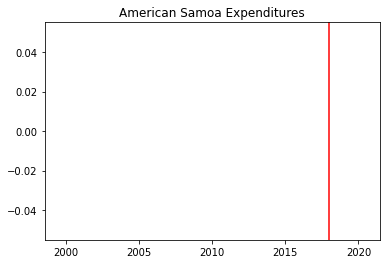

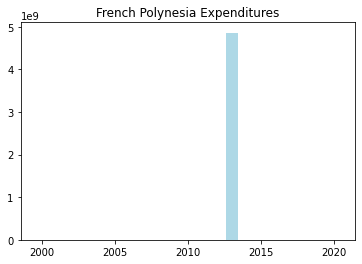

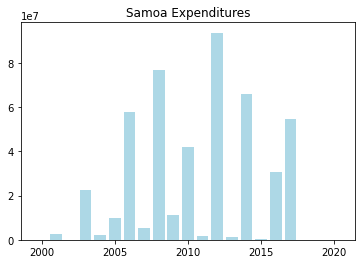

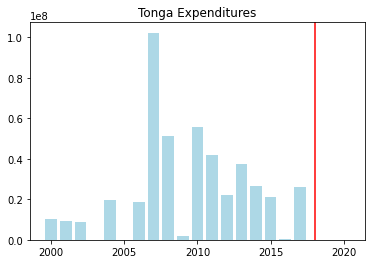

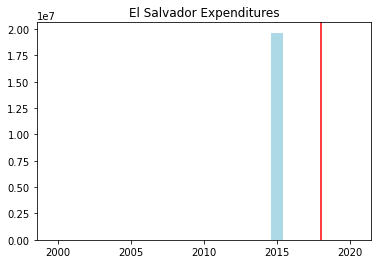

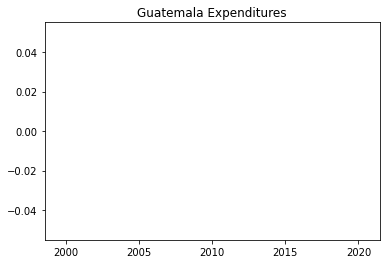

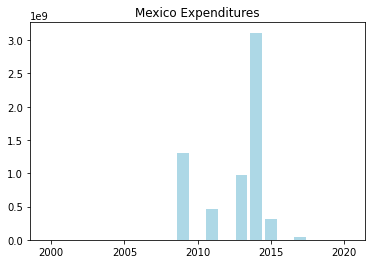

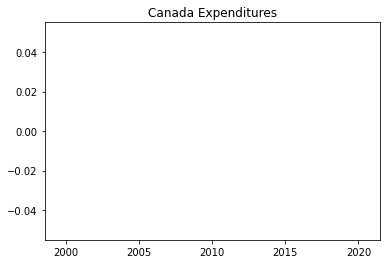

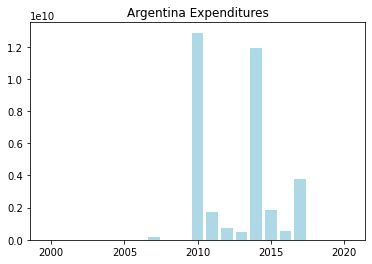

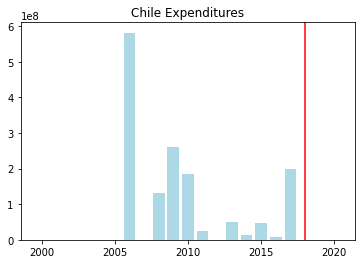

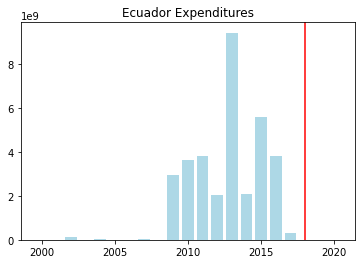

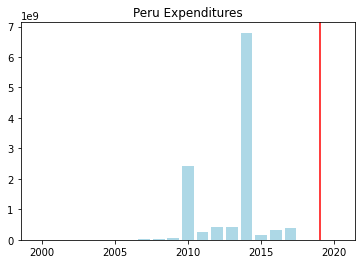

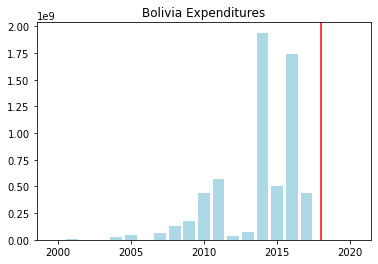

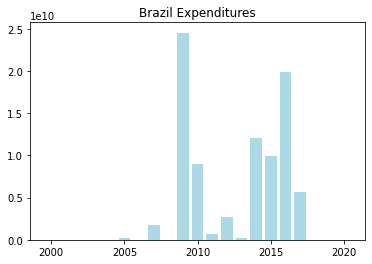

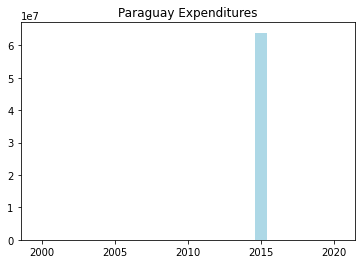

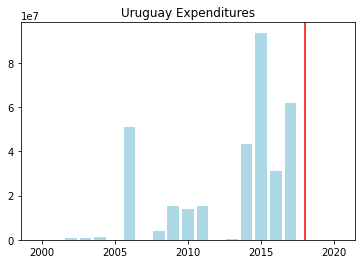

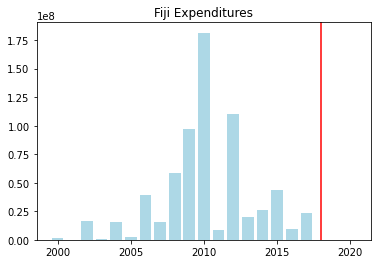

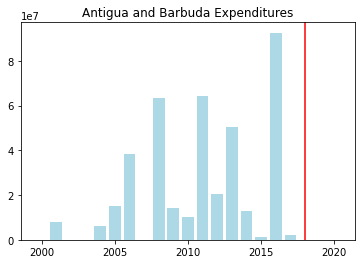

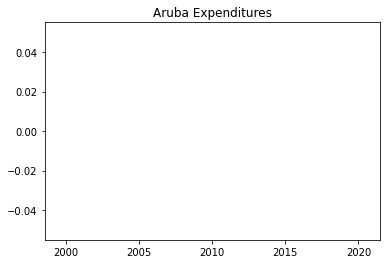

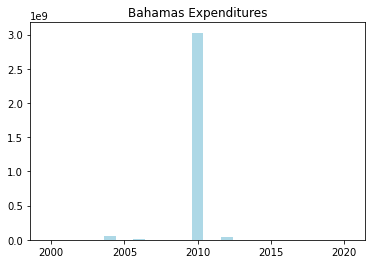

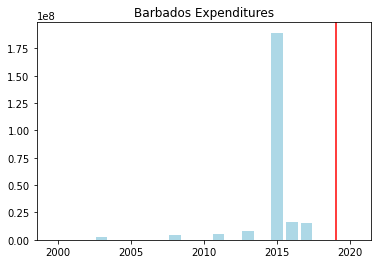

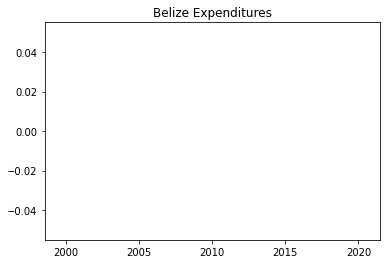

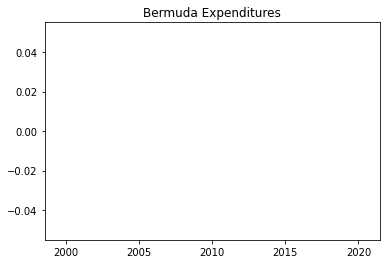

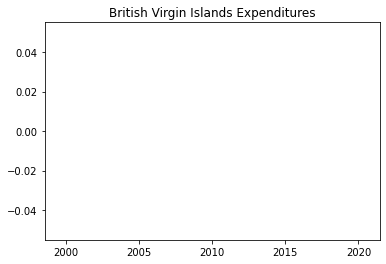

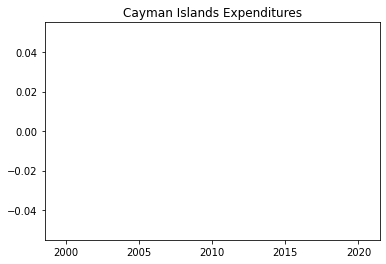

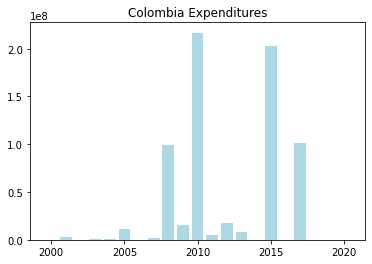

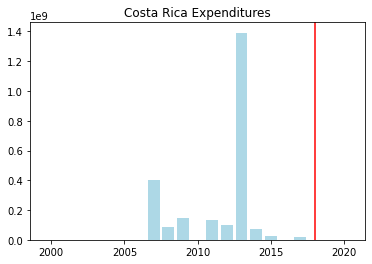

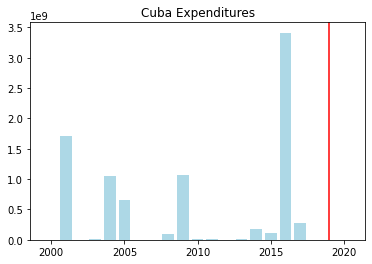

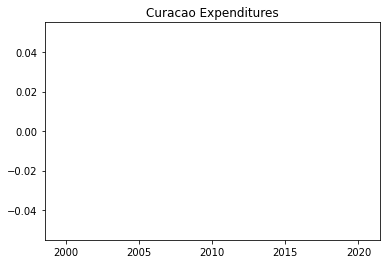

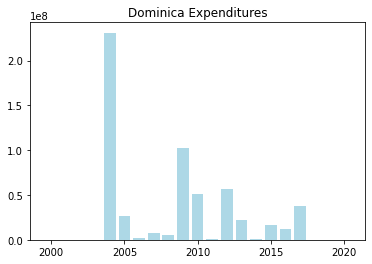

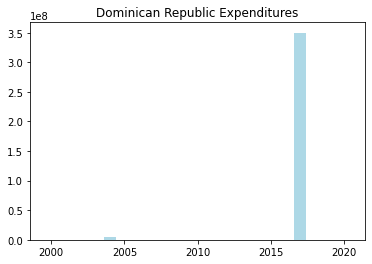

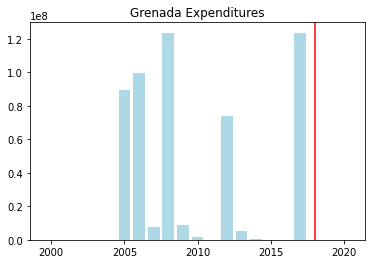

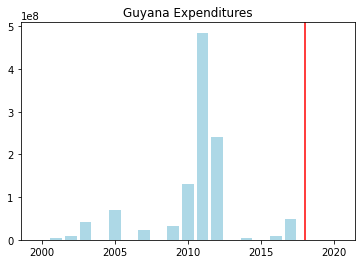

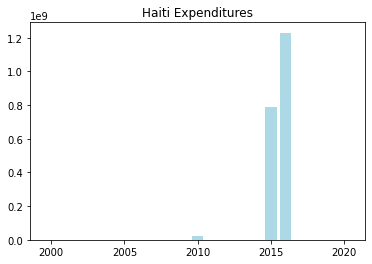

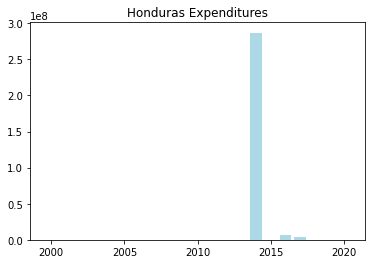

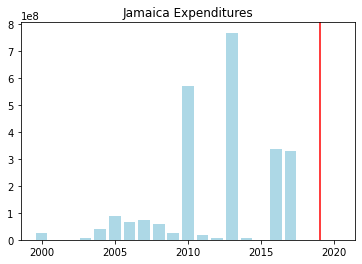

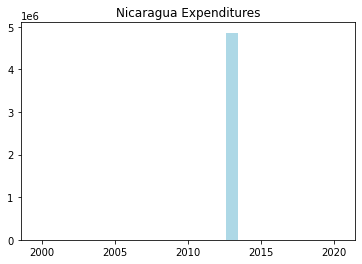

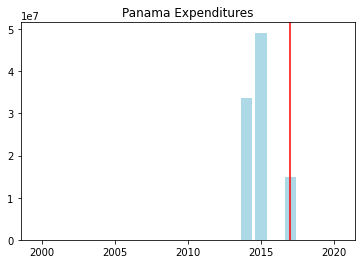

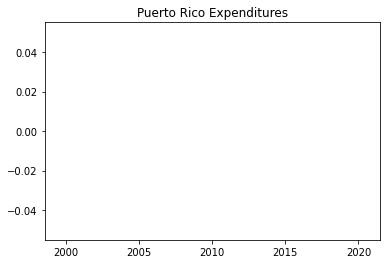

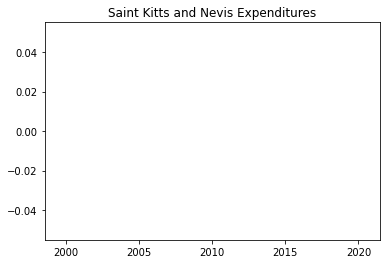

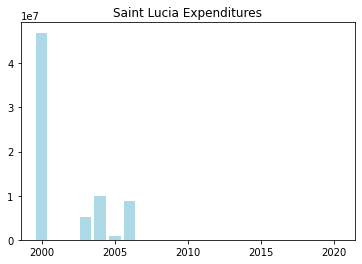

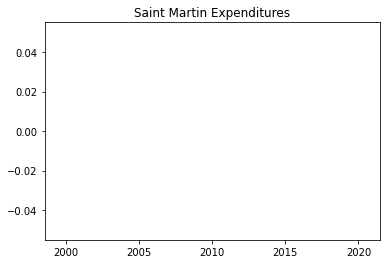

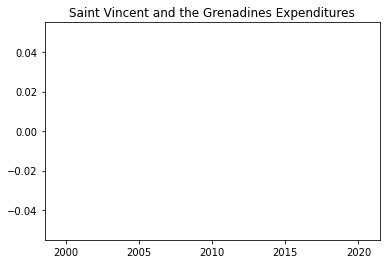

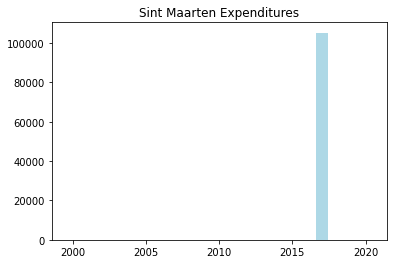

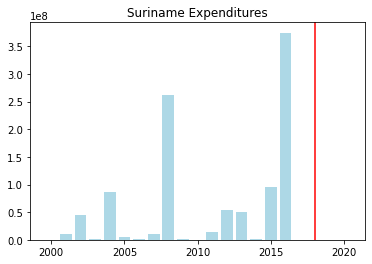

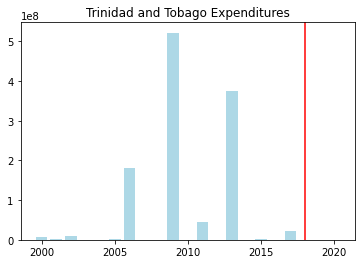

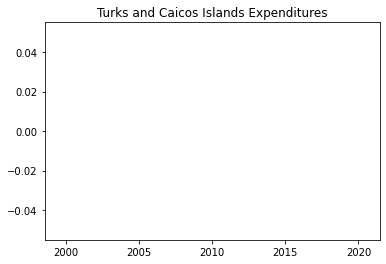

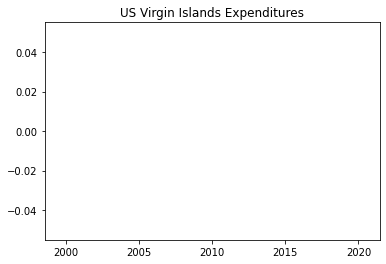

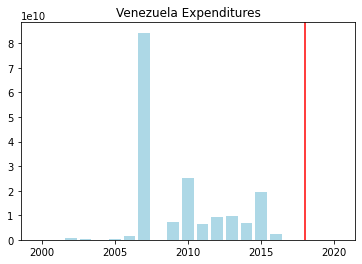

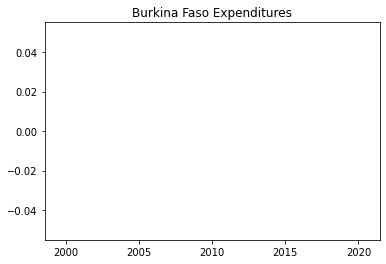

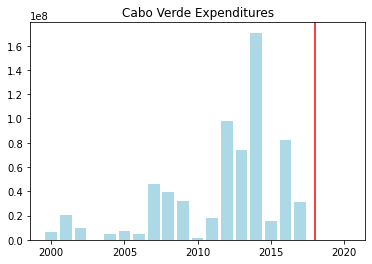

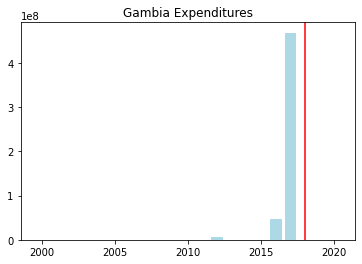

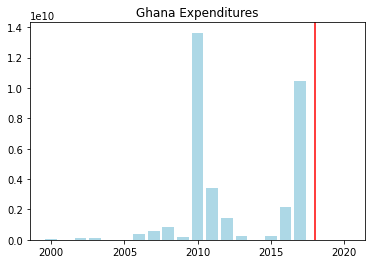

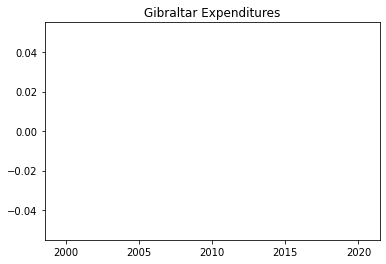

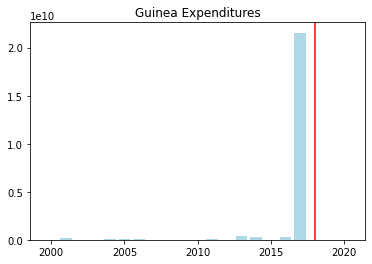

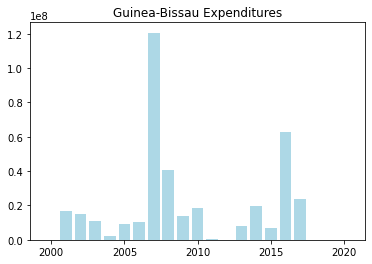

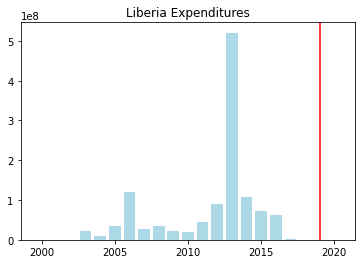

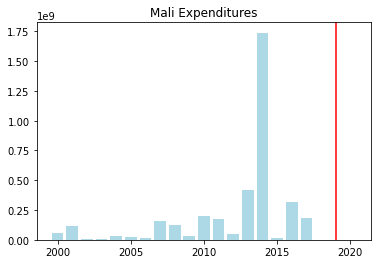

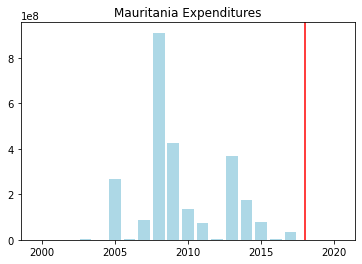

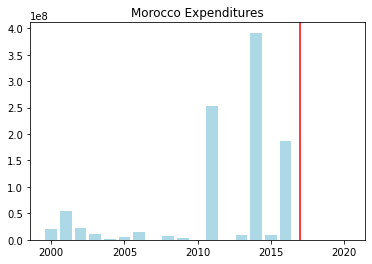

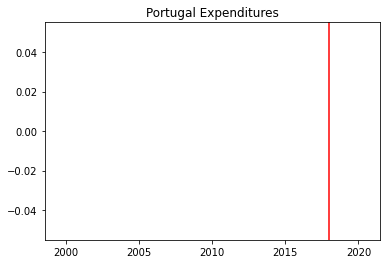

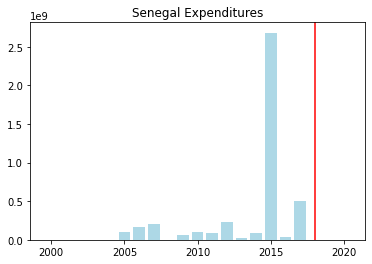

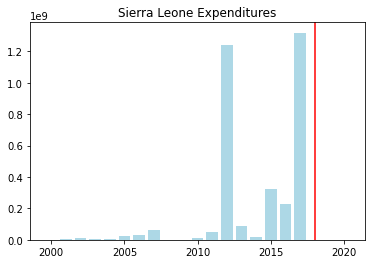

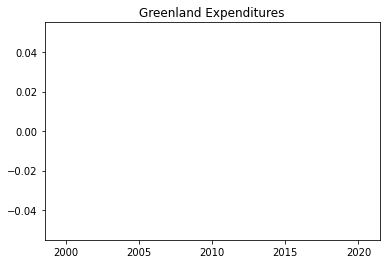

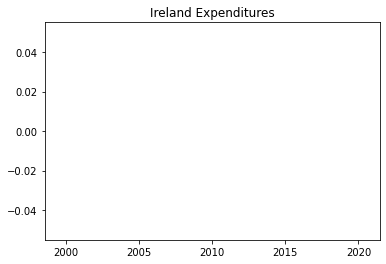

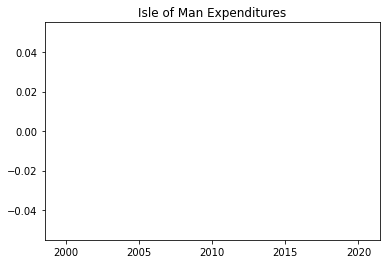

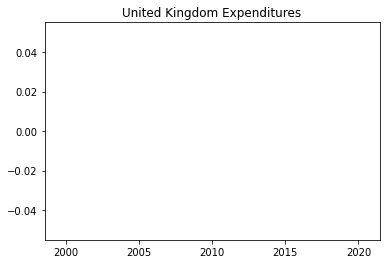

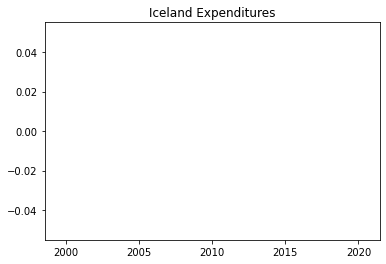

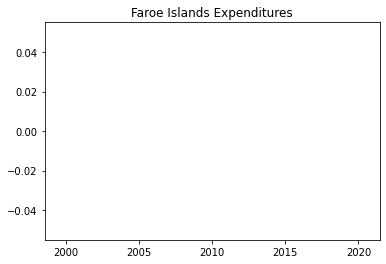

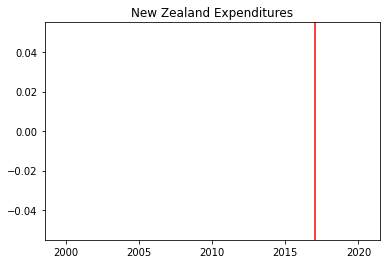

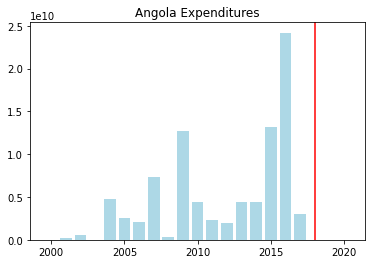

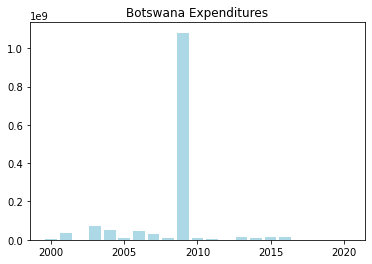

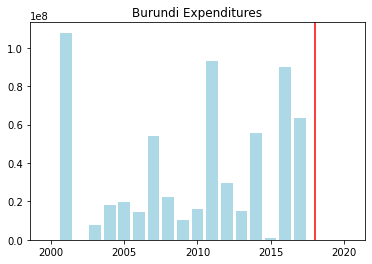

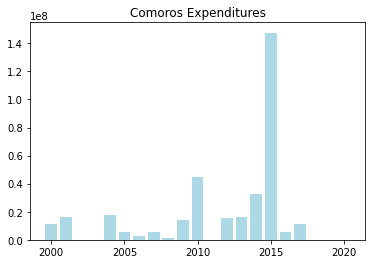

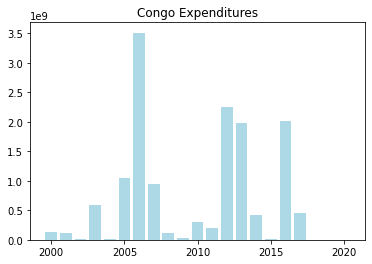

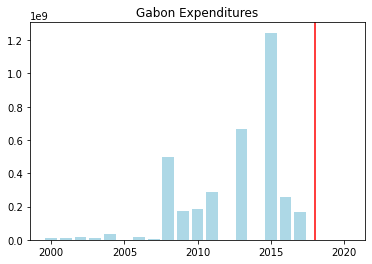

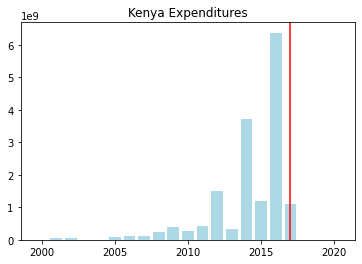

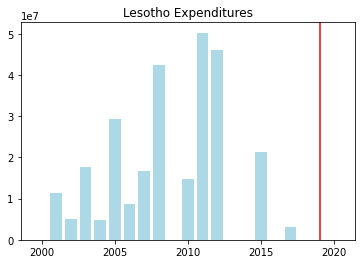

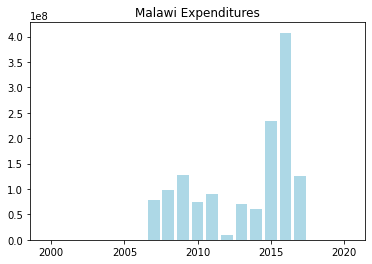

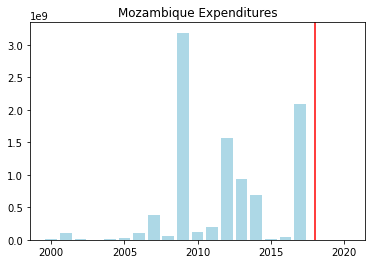

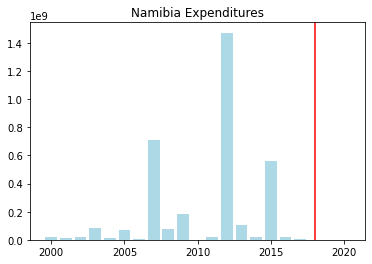

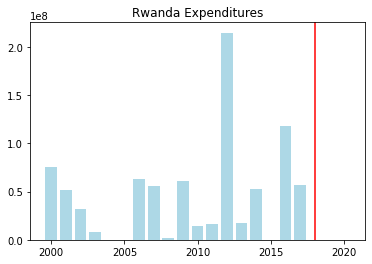

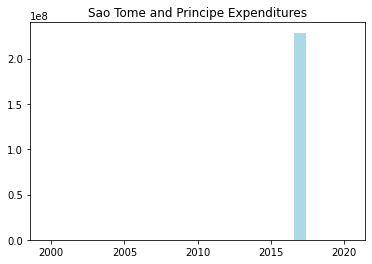

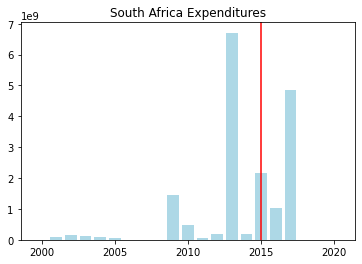

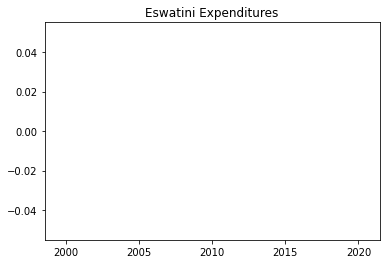

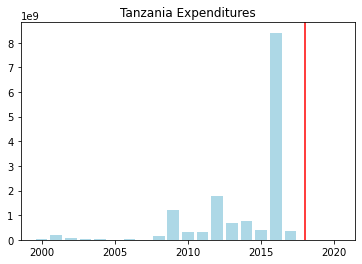

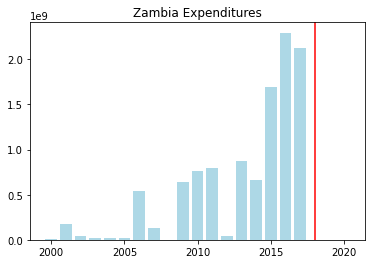

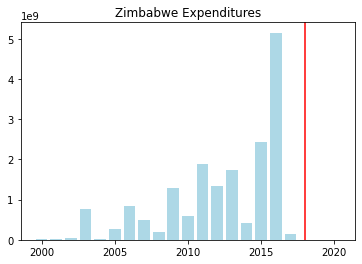

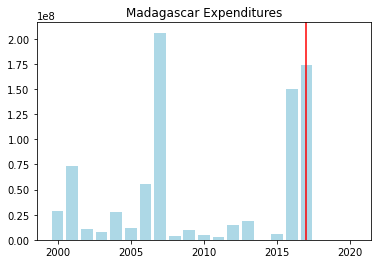

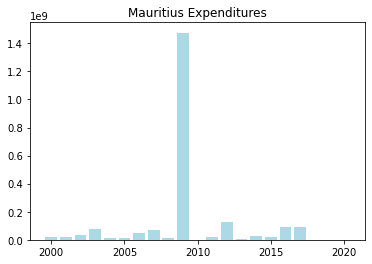

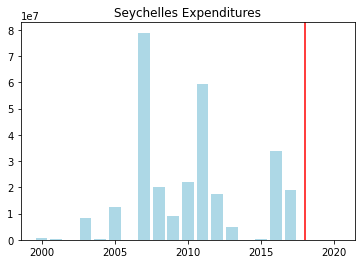

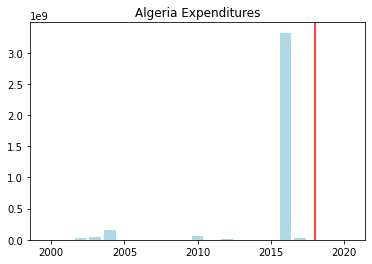

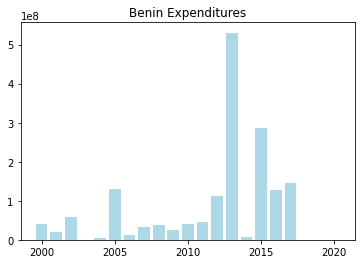

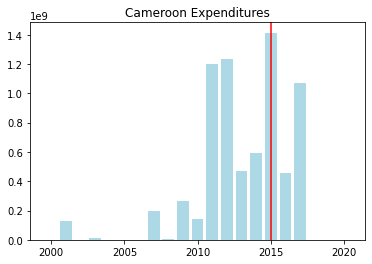

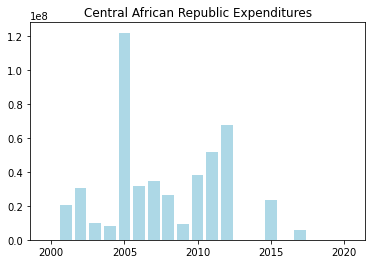

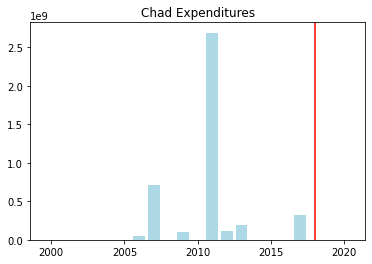

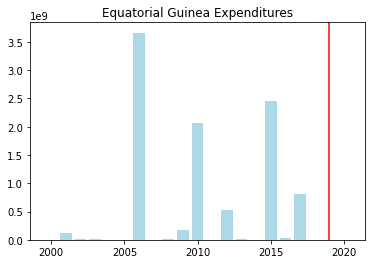

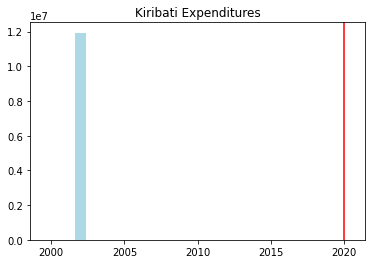

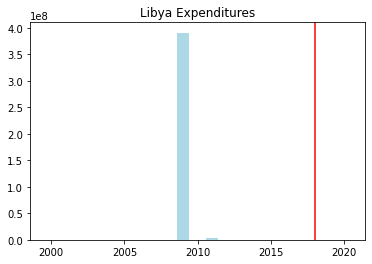

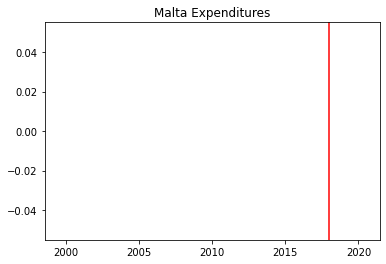

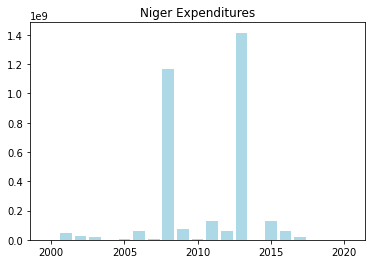

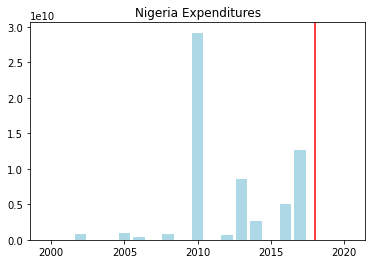

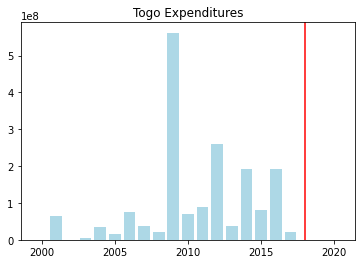

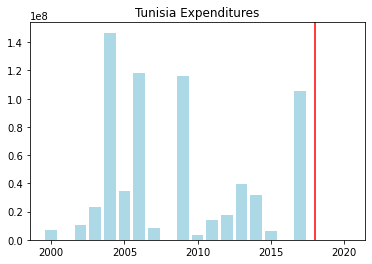

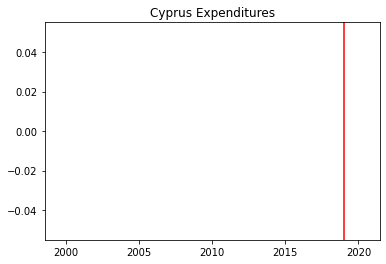

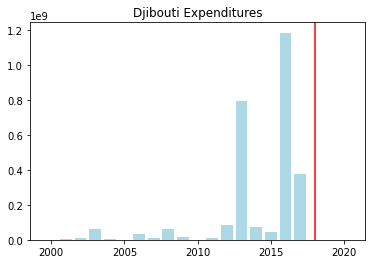

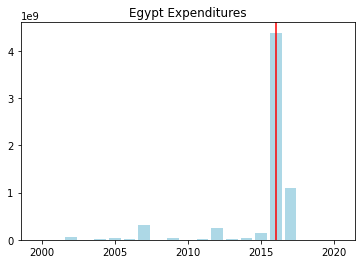

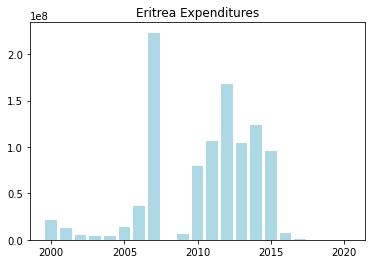

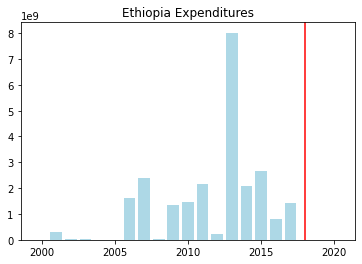

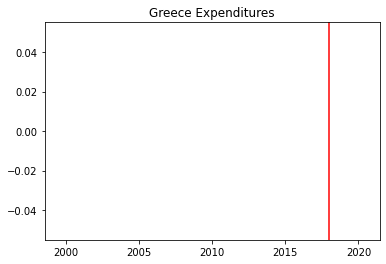

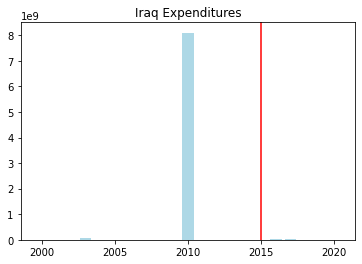

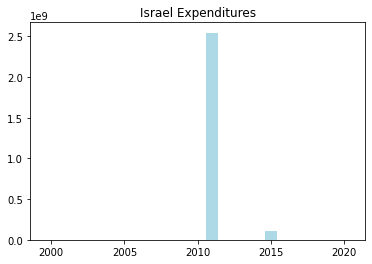

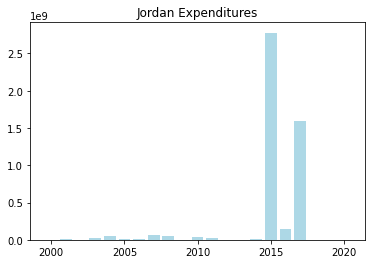

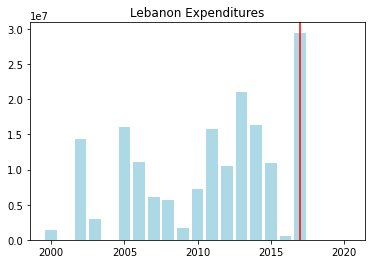

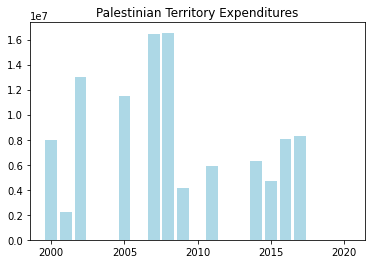

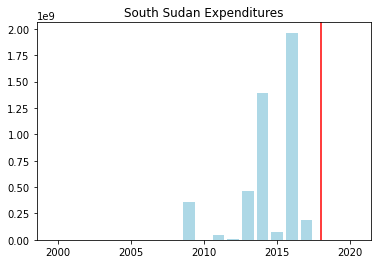

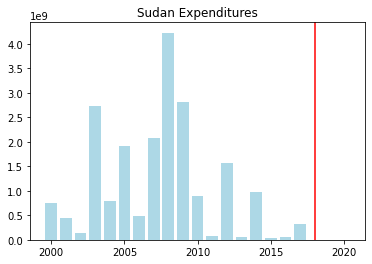

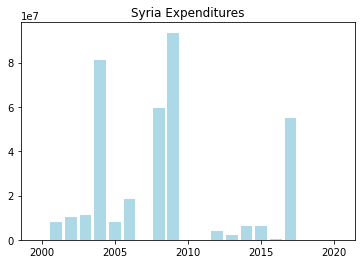

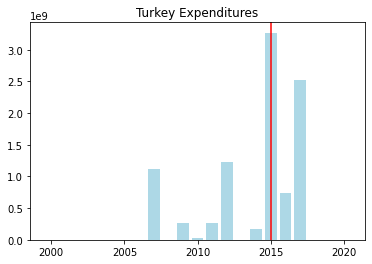

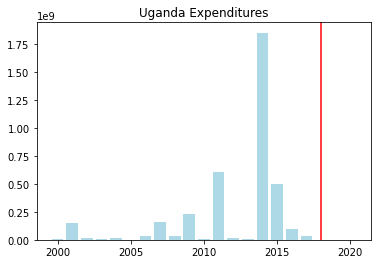

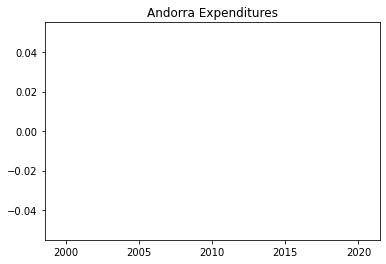

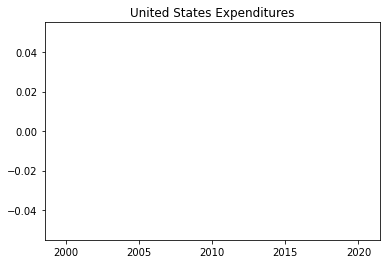

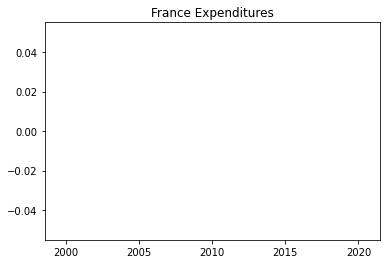

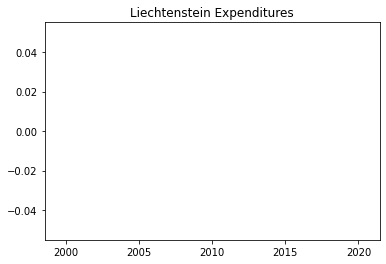

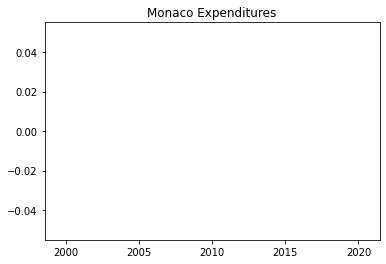

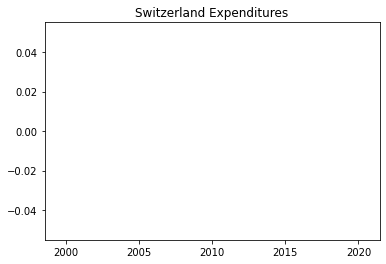

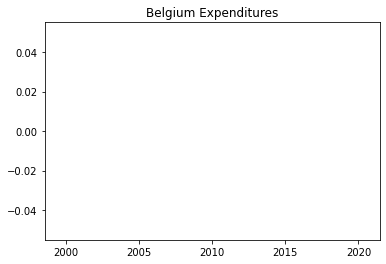

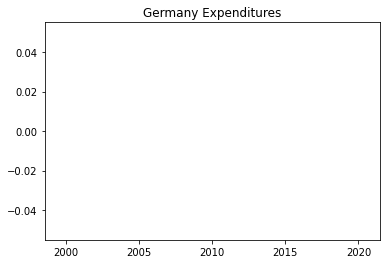

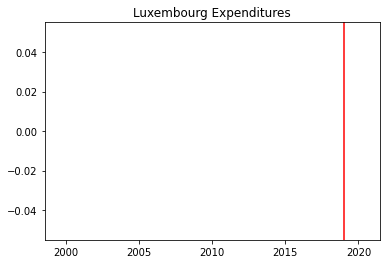

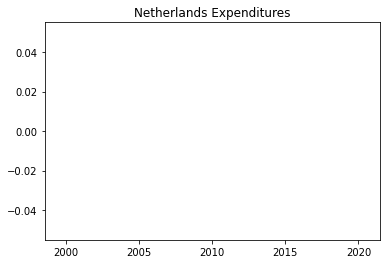

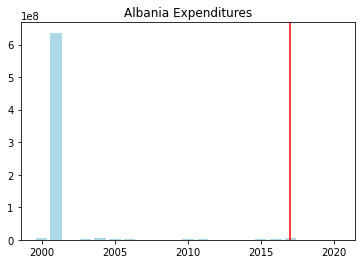

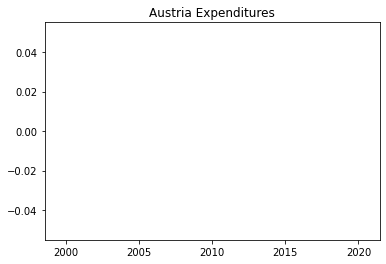

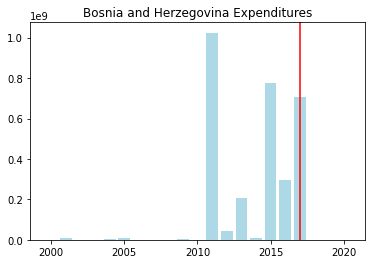

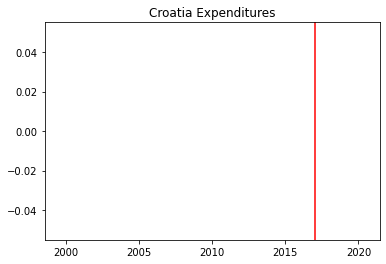

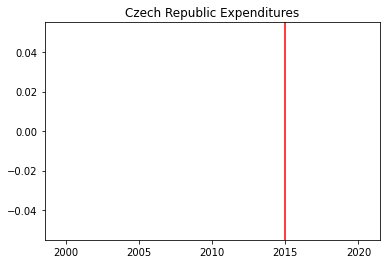

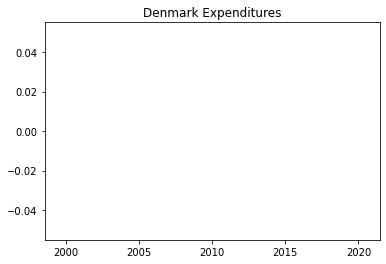

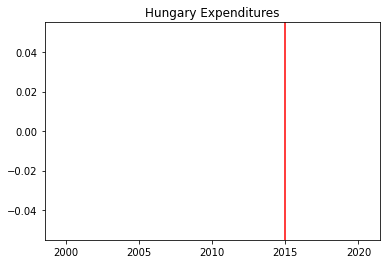

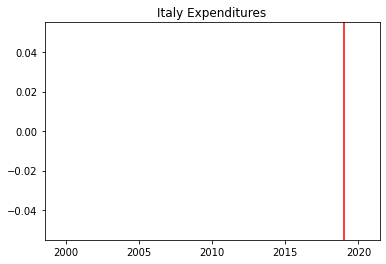

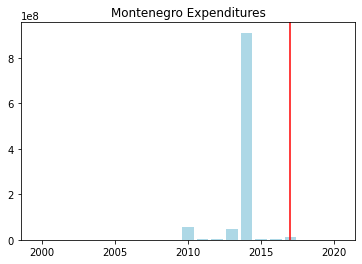

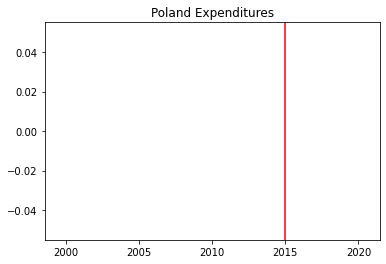

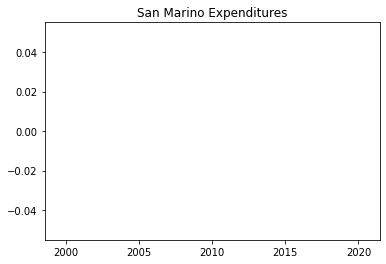

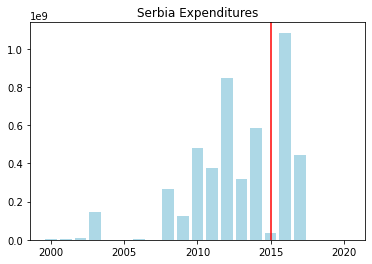

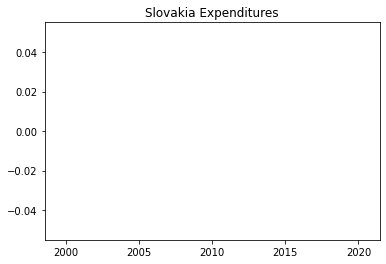

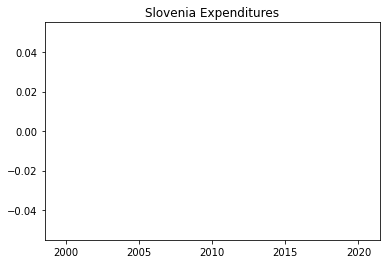

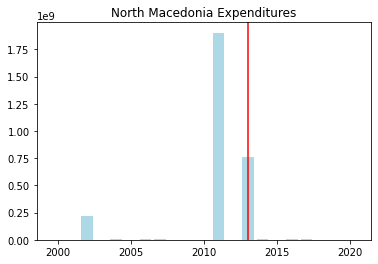

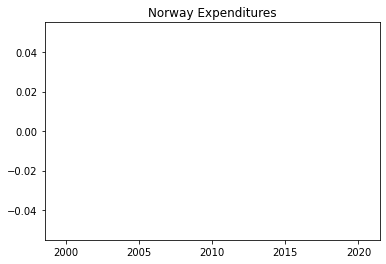

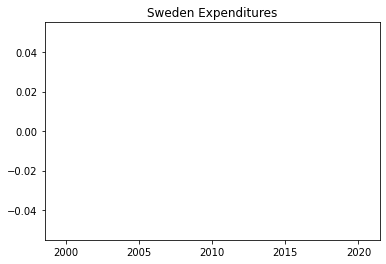

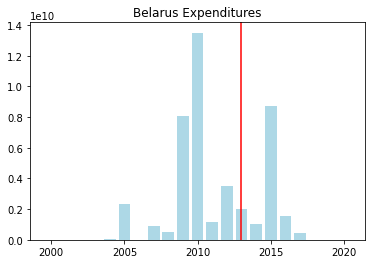

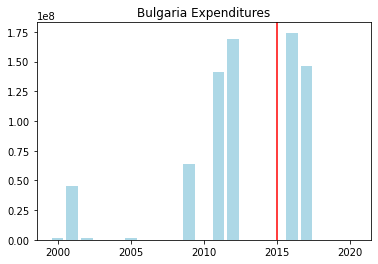

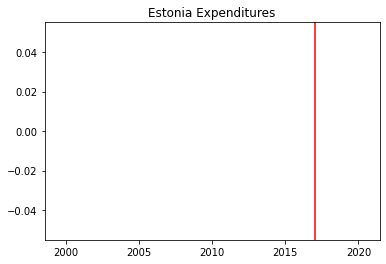

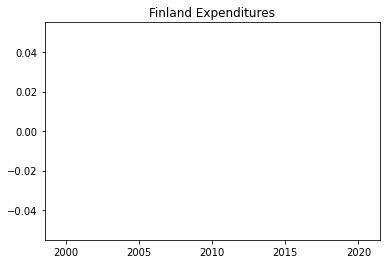

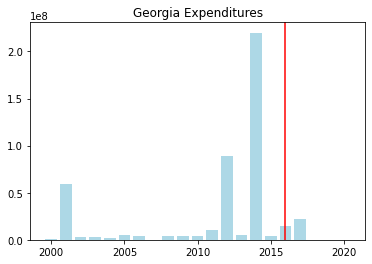

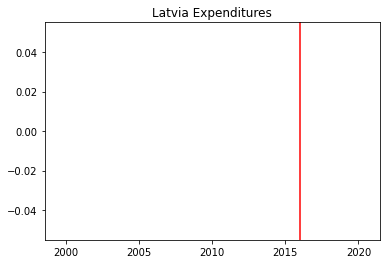

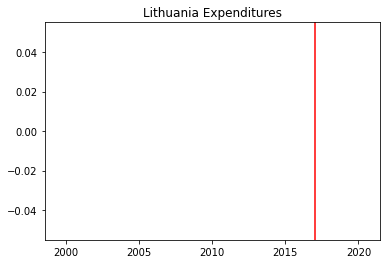

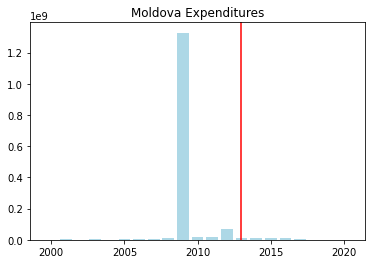

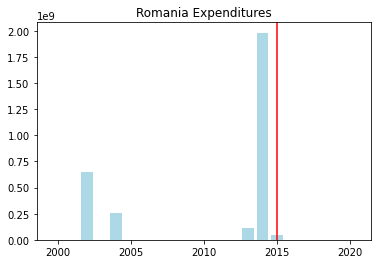

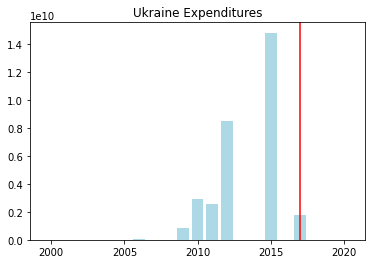

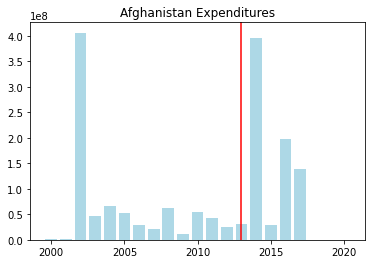

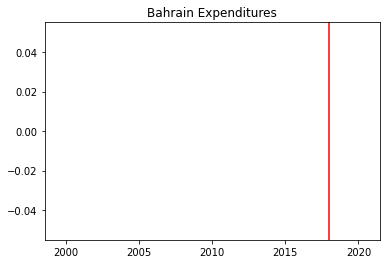

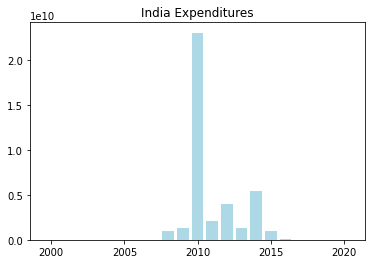

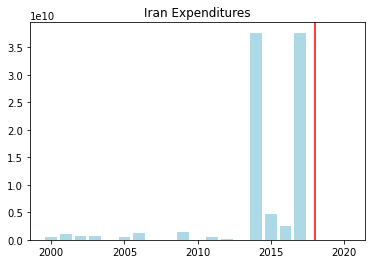

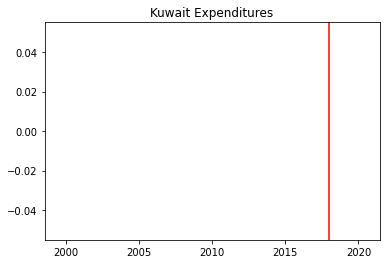

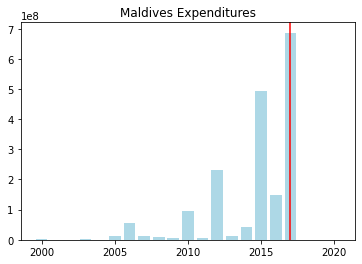

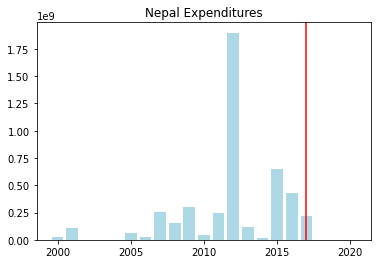

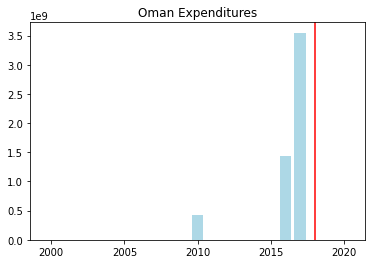

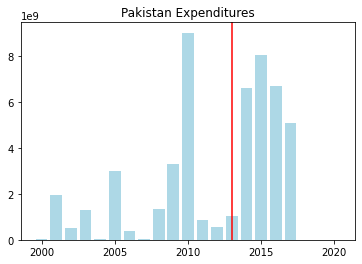

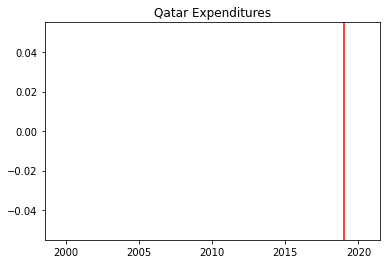

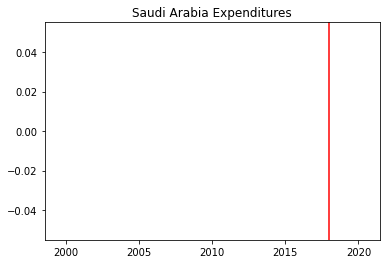

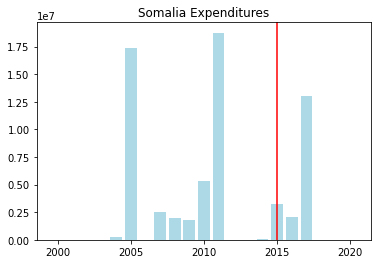

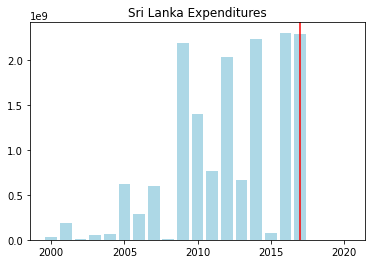

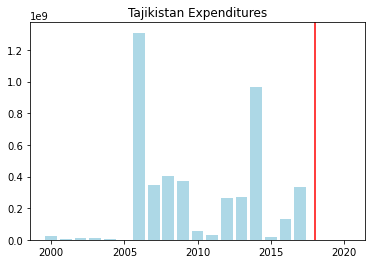

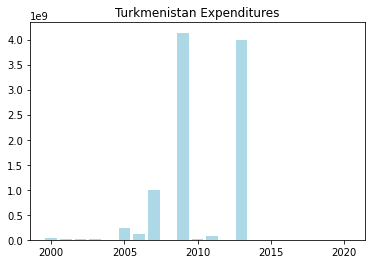

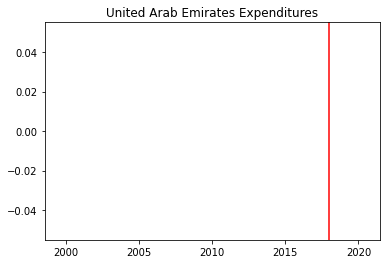

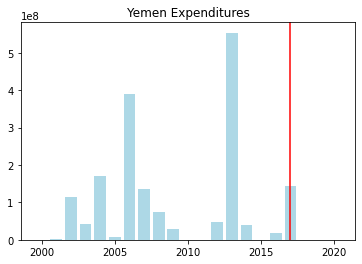

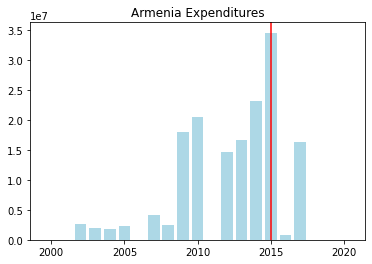

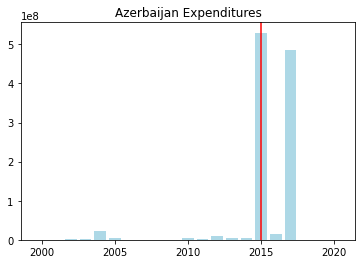

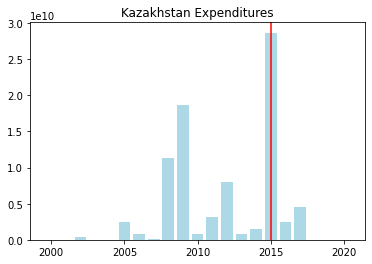

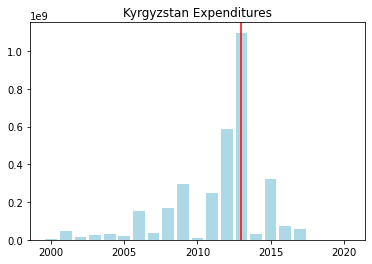

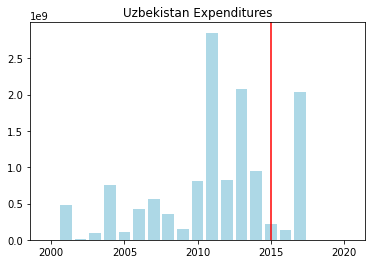

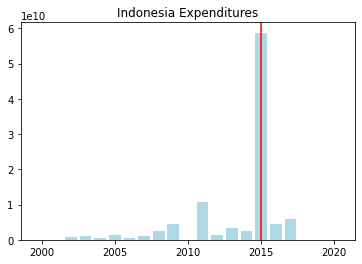

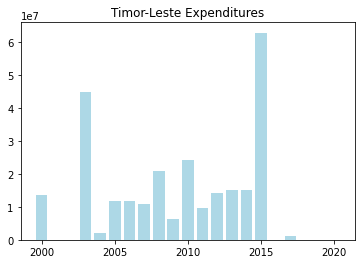

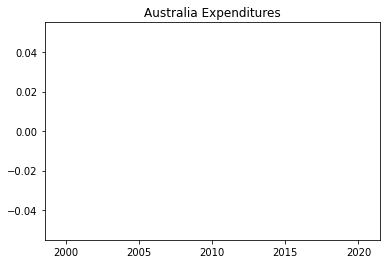

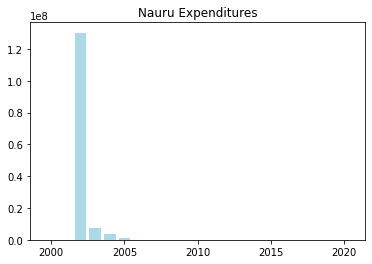

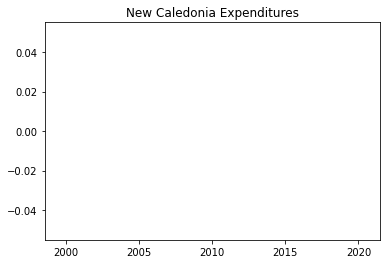

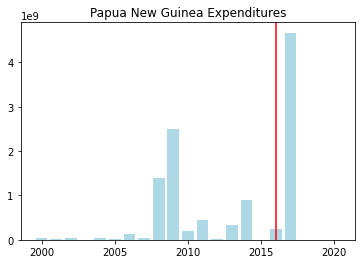

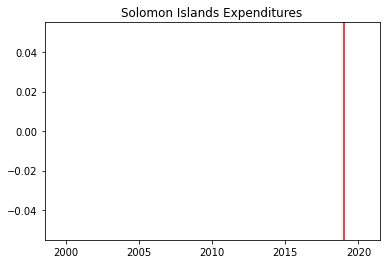

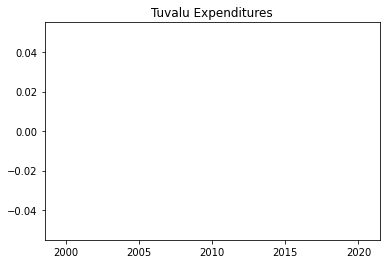

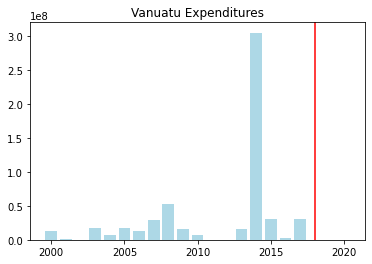

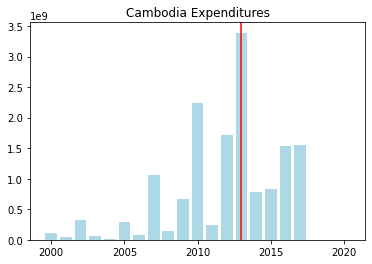

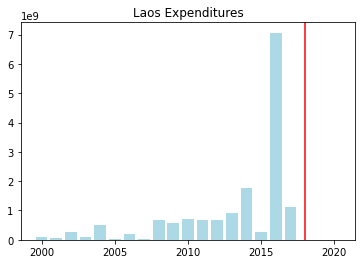

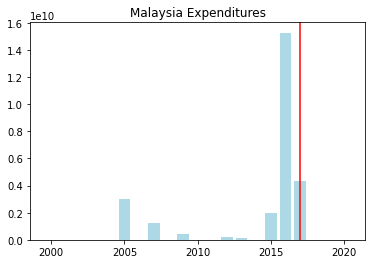

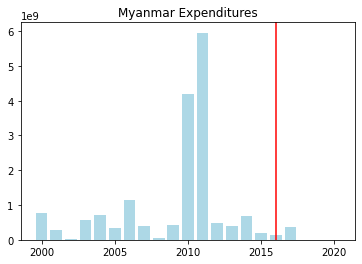

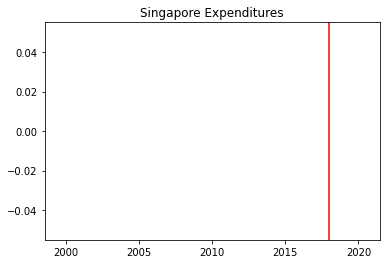

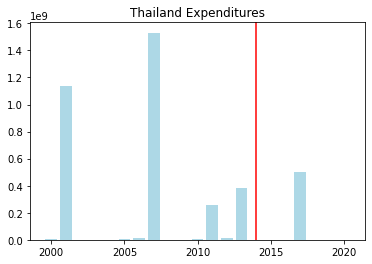

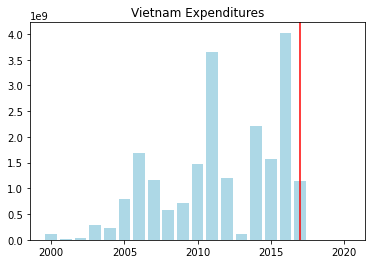

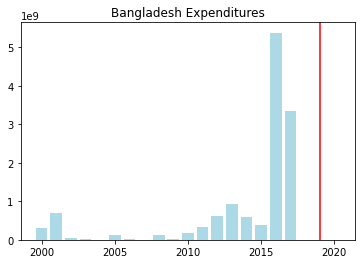

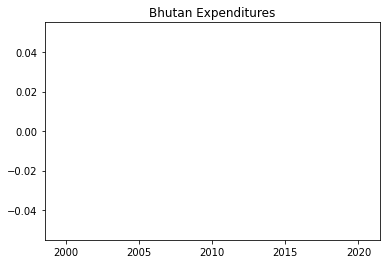

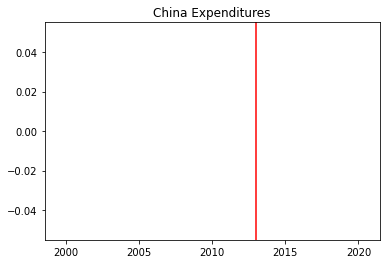

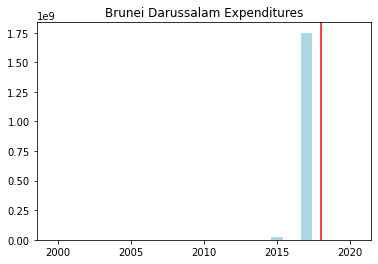

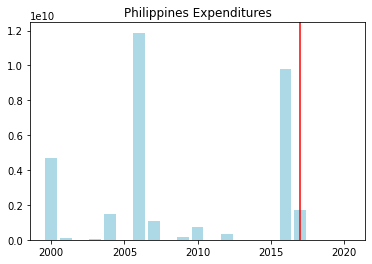

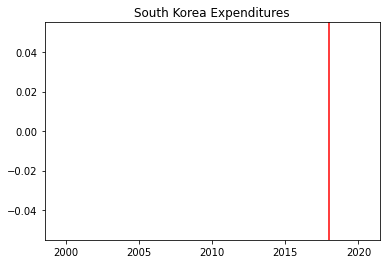

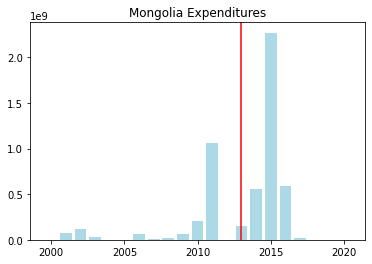

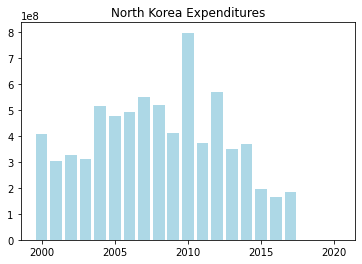

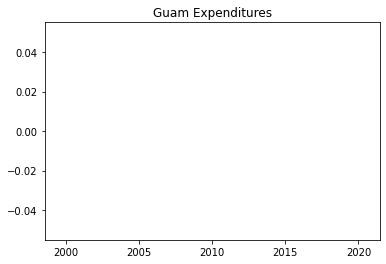

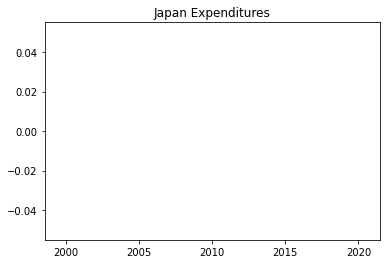

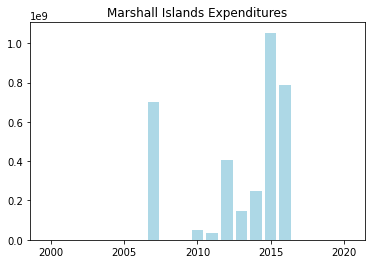

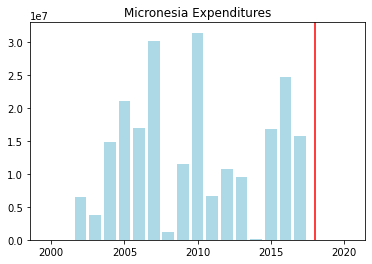

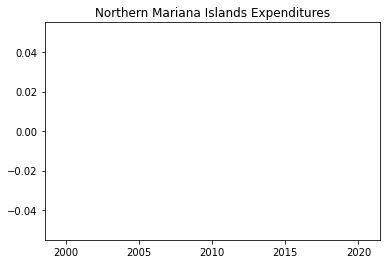

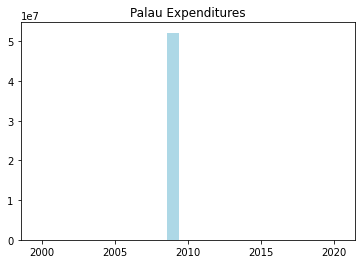

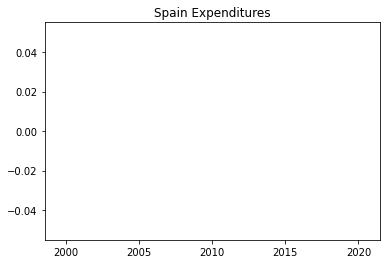

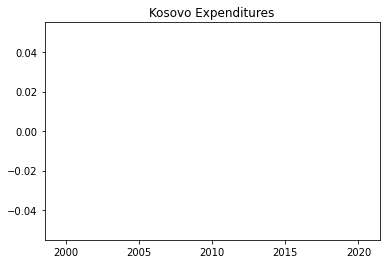

<Figure size 432x288 with 0 Axes>

In [52]:
no_expend = []
for i in range(0, len(countries)):
    country_name = countries['name'][i]
    
    if len(df.index[df['country'] == country_name]) > 0: 
        year = countries['bri_partner'][countries.index[countries['name'] == country_name][0]]
        if year != 0: 
            plt.axvline(x=year, color='r', label='axvline - full height')
        plt.bar(df[df['country'] == country_name]['year'], df[df['country'] == country_name]['expend_sum'], color='lightblue')
        plt.title(country_name + " Expenditures")
        plt.figure()
    else: 
        no_expend.append(country_name)

In [45]:
no_expend = []
no_expend.append("sldkj")

In [46]:
no_expend

['sldkj']

In [ ]:
pd.set_option('display.max_rows', 500)
df.groupby(['country', 'bri_partner']).mean()

In [ ]:
%matplotlib inline
sns.scatterplot(data df.expend_sum, df.bri_partner)
plt.title('Expenditure Totals')
# plt.xlabel('Job')
# plt.ylabel('Frequency of Purchase')

In [ ]:
plt.crosstab(df[[]], df['bri_partner']).plot(kind='bar')

In [ ]:
plt.figure(figsize=(20,12))
df.groupby('country')['expend_sum'].sum().sort_values().plot(kind='bar')

## Begin Model Testing

In [ ]:
# split into data and labels
data = df.drop(columns=['country_id', 'country', 'bri_partner'])
labels = df['bri_partner']

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# extract train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data,\
                                    labels, test_size=0.33,\
                                                random_state=23) 

In [ ]:
def svm(X_train, X_test, y_train, y_test, kernel, C):
    
    # check to make sure the kernel is a valid value 
    if kernel != 'linear' and kernel != 'poly' and kernel != 'sigmoid' and kernel != 'rbf':
        raise ValueError()
    
    # build the classifier 
    print("building")
    clf = SVC(C = C, kernel = kernel)
    print("fitting")
    # fit the classifier to the training data 
    clf.fit(X_train, y_train)
    
    print("predicting")
    predictions = clf.predict(X_test)
    
    # determine the accuracy of the predictions 
    return accuracy_score(y_true = y_test, y_pred = predictions)

In [ ]:
predicted_accuracy = svm(X_train, X_test, y_train, y_test, 'linear', 0.5)
print(f'Accuracy value is {predicted_accuracy}')